<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png' width=250px>

-----
## Quick start
    conda install tensorflow=1.14
    (conda install tensorflow-gpu=1.14)
    
    pip install talos

-----
## Overview
請將您的程式碼遵照下列步驟修改，以套用Talos超參數選擇器:
1. 引用 talos 套件
2. 替你的 Keras model 加入 'params' 標籤
3. 定義 "超參數組合"
4. 執行超參數搜索

- 更多細節 https://autonomio.github.io/talos/#/README?id=quick-start
- 官方範本 https://tinyurl.com/r7gebyz

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

---
### Sub：Metrics

In [3]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [4]:
# 列印績效圖表，可以選擇是否儲存
def showPlot(true, prediction, title, sub_title, size='M', save=False):
    size == 'L' and plt.figure(figsize=(28, 10))
    plt.plot(true, color='red', label='Real')
    plt.plot(prediction, color='blue', label='Prediction')
    plt.title('Industry Elec Prediction %s %s t:%d' % (title, sub_title, time))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    save and plt.savefig('Image/%s-%s-%d.png' % (title, sub_title, time))
    plt.show()

---
### Sub：Data Processing

In [5]:
# 資料維度擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    return data

In [6]:
# 資料正規化與尺度還原
from sklearn.preprocessing import MinMaxScaler
def normalize(data):
    sc = MinMaxScaler(feature_range=(0, 1))
    data_scaled = pd.DataFrame(sc.fit_transform(data))
    return sc, data_scaled
def deNormalize(sc, value):
    value_unscaled = value * \
        (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    value_unscaled = value_unscaled.reshape(value_unscaled.shape[0])
    return value_unscaled

In [7]:
# 根據給定的時間範圍自動產生訓練集
def split_train(data, trainFrom, trainTo, pastDay=7, futureDay=7):
    num_train_from = df[df['Date'] == trainFrom].index.item()
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    RawTrain = data[num_train_from:num_train_to]
    print('RawTrain', RawTrain.shape)
    return RawTrain
# 根據給定的時間範圍自動產生測試集
def split_test(data, testFrom, testTo, pastDay=7, futureDay=7):
    num_test_from = df[df['Date'] == testFrom].index.item()
    num_test_to = df[df['Date'] == testTo].index.item() + 1
    RawTest = data[num_test_from-pastDay:num_test_to]
    print('RawTest', RawTest.shape)
    return RawTest
# 拆分訓練與驗證，需要手動切割時才使用
def split_val(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [8]:
# 滾動訓練資料
def buildTrain(train, pastDay, futureDay):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])  # kW
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [9]:
# 滾動測試資料
def buildTest(test, pastDay, futureDay):
    input_set, truth_set = test, test[pastDay:]
    X_test, Y_truth = [], []
    for i in range(0, int((test.shape[0]-pastDay)/futureDay)):
        X_test.append(input_set[futureDay*i:futureDay*i+pastDay])
        Y_truth.append(truth_set[i*futureDay:(i+1)*futureDay, 0])  # kW
    testInput, testTruth = np.array(X_test), np.array(Y_truth)
    testInput = testInput.reshape(testInput.shape[0], testInput.shape[1], testInput.shape[2])
    testTruth = testTruth.reshape(testTruth.shape[0] * testTruth.shape[1])
    print('testInput.shape, testTruth.shape', testInput.shape, testTruth.shape)
    return testInput, testTruth

---
### Sub：Model
Configuring the Keras Model for Talos

In [10]:
# 分配顯存空間，未使用 tensorflow-GPU 可以跳過這段
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.45
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


## [Talos] 1.引用 talos 套件

In [11]:
# Import the talos libraries and packages
import sys
import talos

In [12]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## [Talos] 2.替你的 Keras model 加入 'params' 標籤

In [13]:
# first we have to make sure to input data and params into the function
def create_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(SimpleRNN(units=params['layer_1_node'], input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Activation('relu')) # model.add(Activation(params['activation']))
    model.add(RepeatVector(7))

    model.add(SimpleRNN(params['layer_2_node'], return_sequences=True))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))

    model.add(TimeDistributed(Dense(params['layer_3_node'], activation='relu')))
    model.add(Dropout(params['dropout']))
    
    model.add(Flatten())
    model.add(Dense(units=futureDay))  # futureDay=7

    model.compile(loss='mse', optimizer='adam')
    
    reduceLR = ReduceLROnPlateau(
        monitor='val_loss', factor=params['reduceLR_rate'], 
        patience=params['reduceLR_t'], mode='min', verbose=0)
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=100, mode="min", 
        restore_best_weights=True)

    history = model.fit(x_train, y_train,
                        validation_data=[x_val, y_val],
                        epochs=1000, batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[reduceLR, earlyStop])
    
    return history, model

## [Talos] 3.定義 "超參數組合"

In [1]:
p = {'reduceLR_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5],
     'reduceLR_t': [10, 20, 50],
     'dropout': [0.0, 0.1, 0.01, 0.001],
     'layer_1_node': [50, 100, 200, 300, 400],
     'layer_2_node': [50, 100, 200],
     'layer_3_node': [50, 100, 200],
     'batch_size': [16, 32]
     }

In [15]:
def model_forecast(model, input_data):
    forecast_temp = model.predict(input_data)
    forecast = forecast_temp.reshape(
        forecast_temp.shape[0] * forecast_temp.shape[1])
    return forecast

In [16]:
def model_evaluate(model, sc, truth, input_set):
    truth = pd.DataFrame(truth)
    truth = deNormalize(sc, truth.values)
    predict = model_forecast(model, input_set)
    predict = deNormalize(sc, predict)
    return predict

---
### Main

In [17]:
df = pd.read_csv('Data/industryElec_processed_20160101_20190930.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1369, 12)

In [18]:
features = [
    'kW',
    'PeakLoad(MW)_shift7',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7'
]

In [19]:
# 預測時間
trainFrom = '2017-01-04'
trainTo = '2019-01-01'
testFrom = '2019-01-02'
testTo = '2019-09-24'
# 步數選擇
pastDay = 7
futureDay = 7

In [20]:
# 特徵選取
RawData = augFeatures(df, features)

# 正規化
sc, RawData = normalize(RawData)

# 資料範圍選取
RawTrain = split_train(RawData, trainFrom, trainTo, pastDay, futureDay)
RawSelf = split_test(RawData, '2017-01-11', '2019-01-01', pastDay, futureDay)
RawTest = split_test(RawData, testFrom, testTo, pastDay, futureDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, pastDay, futureDay)
selfInput, selfTruth = buildTest(RawSelf.values, pastDay, futureDay)
testInput, testTruth = buildTest(RawTest.values, pastDay, futureDay)

# 驗證資料
# X, Y, Xv, Yv= split_val(X_train, Y_train, 0.3)

RawTrain (728, 6)
RawTest (728, 6)
RawTest (273, 6)
X_train.shape, Y_train.shape (714, 7, 6) (714, 7)
testInput.shape, testTruth.shape (103, 7, 6) (721,)
testInput.shape, testTruth.shape (38, 7, 6) (266,)


## [Talos] 4.執行超參數搜索

In [21]:
%%time
# run the experiment
# fraction_limit = 要從所有的可能性中隨機挑選多少比例的組合進行實驗
scan_object = talos.Scan(x=X_train, y=Y_train, val_split=0.1,
                         model=create_model,
                         params=p,
                         reduction_metric='val_loss', minimize_loss=True,
                         fraction_limit=0.5, 
                         experiment_name='breast_cancer')

  0%|                                                                                          | 0/270 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 270/270 [9:04:22<00:00, 120.97s/it]

Wall time: 9h 4min 22s


## [Talos] 檢視實驗結果

In [22]:
scan_object_top10 = scan_object.data.sort_values(["val_loss"],ascending=True).head(10)
# 打印檢視
scan_object_top10

,round_epochs,val_loss,loss,lr,activation,batch_size,dropout,layer_1_node,layer_2_node,layer_3_node,losses,lr_reduce_rate
129,226,0.001147,0.000364,1.000000e-10,relu,16,0.0,300,100,50,mean_squared_error,0.10
217,281,0.001178,0.000032,1.953125e-06,relu,16,0.0,400,200,100,mean_squared_error,0.50
180,236,0.001178,0.000381,6.561000e-08,relu,16,0.0,200,100,50,mean_squared_error,0.30
83,197,0.001197,0.000396,1.000000e-10,relu,16,0.0,300,200,200,mean_squared_error,0.10
252,200,0.001198,0.000384,1.000000e-10,relu,16,0.0,400,200,50,mean_squared_error,0.10
16,231,0.001209,0.000282,2.187000e-07,relu,16,0.0,200,50,50,mean_squared_error,0.30
93,354,0.001210,0.000757,6.103516e-08,relu,16,0.1,300,100,50,mean_squared_error,0.50
139,216,0.001210,0.000467,1.000000e-17,relu,16,0.0,200,200,200,mean_squared_error,0.01
179,201,0.001214,0.000203,6.561000e-08,relu,16,0.0,200,200,200,mean_squared_error,0.30
108,180,0.001228,0.000191,7.290000e-07,relu,16,0.0,200,200,100,mean_squared_error,0.30


In [23]:
# 輸出結果
dfOut = pd.DataFrame(scan_object_top10)
dfOut.to_csv('talos_hypers_temp.csv')

## [Talos] 分析實驗結果
以下示範檢視模型對參數組合的反應幅度及參數重要性

In [24]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

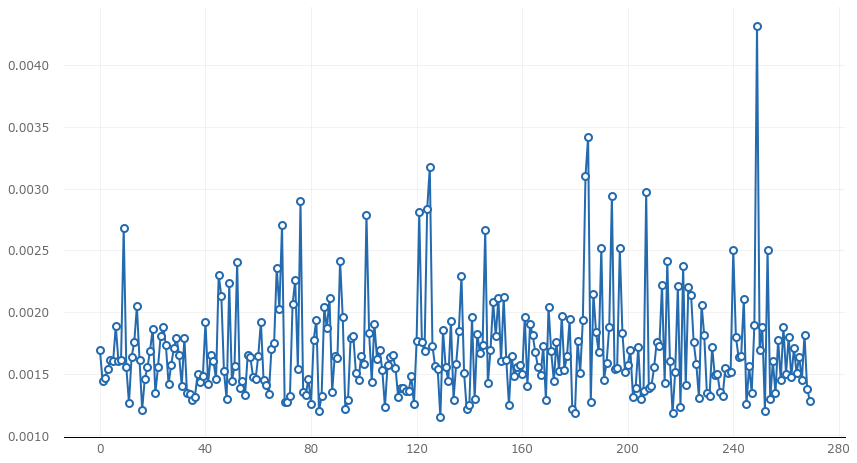

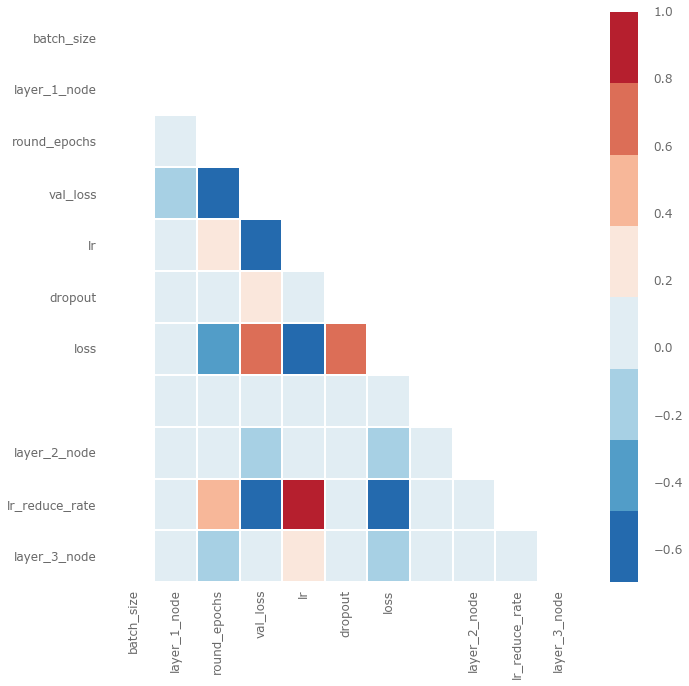

In [35]:
# line plot
# analyze_object.plot_line('val_mae')
analyze_object.plot_line('val_loss')

# up to two dimensional kernel density estimator
# analyze_object.plot_kde('val_loss')

# heatmap correlation
analyze_object.plot_corr('val_loss', ['val_mae'])

# a four dimensional bar grid
# analyze_object.plot_bars('batch_size', 'val_mae', 'layer_1_node', 'lr')

## [Talos] 使用最佳模型預測

In [26]:
time = 0
save = True
model_name = '(Talos_Best_Model_RNN)'

In [27]:
# 獲取最佳模型，必須提供判斷模型優劣的指標
best_model =  scan_object.best_model(metric='val_loss', asc=True)

In [28]:
%%time
total_self = []
total_test = []

# 為求公平衡量模型，執行 n次
for i in range(1):
    print("round: ", str(i))
    self_predict = model_evaluate(best_model, sc, selfTruth, selfInput)
    test_predict = model_evaluate(best_model, sc, testTruth, testInput)
    total_self.append(self_predict.reshape(self_predict.shape[0]))
    total_test.append(test_predict.reshape(test_predict.shape[0]))

# 平均處理 n個模型的預測結果
mean_self = np.array(total_self).mean(axis=0)
mean_test = np.array(total_test).mean(axis=0)

round:  0
Wall time: 128 ms


RMSE 3.875156465897627
MAPE 0.8437417830967516


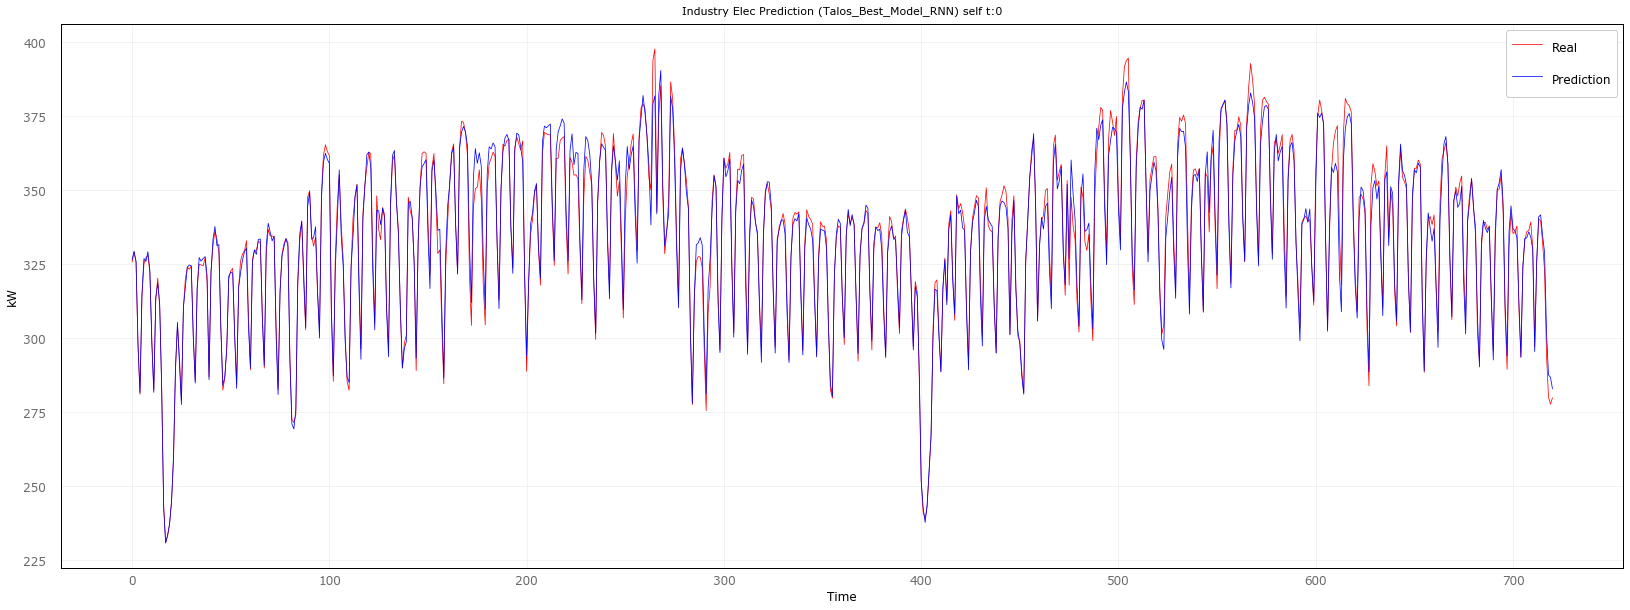

In [29]:
# 自我測試
self_trurh = pd.DataFrame(selfTruth)
self_trurh = deNormalize(sc, self_trurh.values)
calcError(self_trurh, mean_self)
showPlot(self_trurh, mean_self, model_name, "self", size="L", save=save)

RMSE 10.342435110116178
MAPE 2.3662281173423985


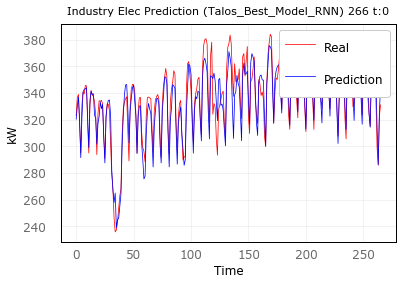

In [30]:
# 實際測試
test_trurh = pd.DataFrame(testTruth)
test_trurh = deNormalize(sc, test_trurh.values)
calcError(test_trurh, mean_test)
showPlot(test_trurh, mean_test, model_name, str(len(testTruth)), save=save)

In [31]:
import h5py
best_model.save('Model/talos_model_%d.h5'%(time))